# 0. Galaxy classification using convolutional neural networks

In this notebook, we attempt to classify galaxies according to their shape using CNN.


The data in this example is a subset of the [Galaxy10 dataset](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/). The images are categorized according to their shapes. We use a slimmed down dataset which contains 8 classes:

'Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge'.


The aim of this work is to train a neural network to classify the galaxy images. 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.7.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA.  **Please make sure you run the cell below to download the data.** 

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called `sciml-workshop-data`.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration 
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Astronomy')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Astronomy/"
files_to_download = ["Galaxy8.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

The slimmed down dataset, which include the images with 8 labels, are stored in the h5 file `Galaxy8.h5`. We load this file using a `h5py` library.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])

In [5]:
# downsample the images - so that the model fits in memory.
x = x[:, ::2, ::2]

# normalise images    
x = x / 255.0

# split train test
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)


# string labels
string_labels = ['Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral',
                 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0, :, :, 0].shape))
print("Number of channels: %s" % str(train_images.shape[-1]))


Number of training data: 6400
Number of test data: 1600
Image pixels: (64, 64)
Number of channels: 3


### We can randomly plot some images and their labels

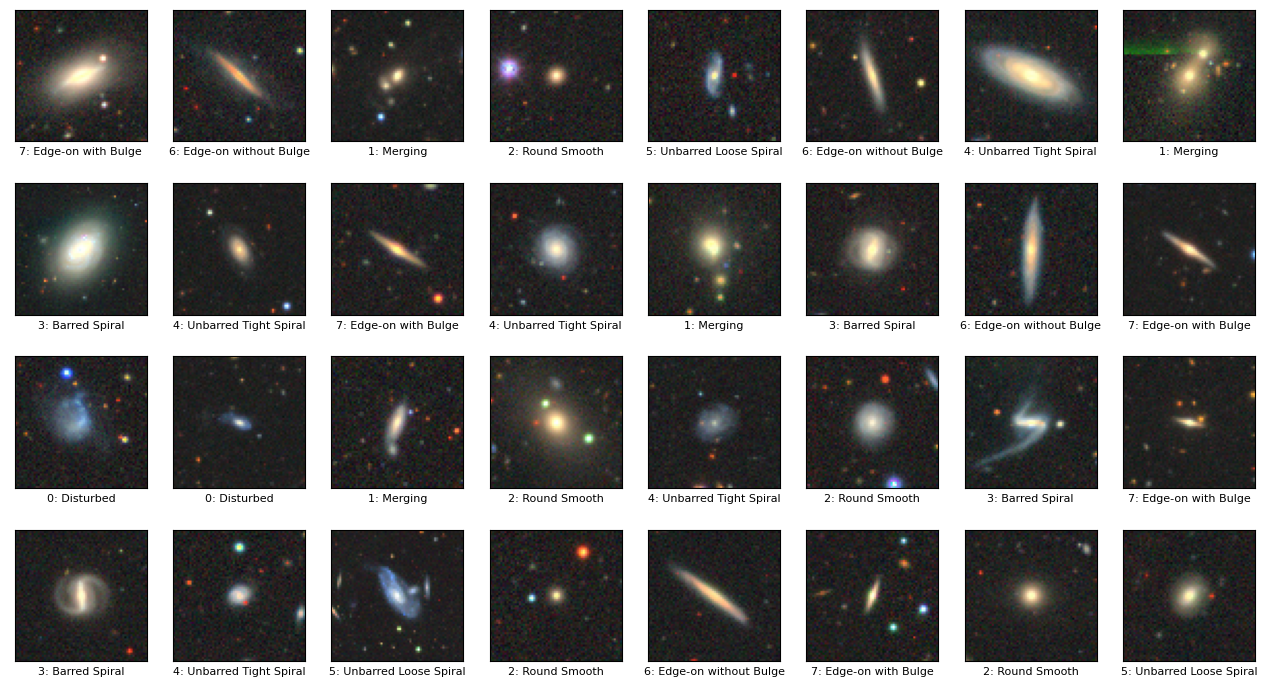

In [6]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

In this case, we have 8 classes. Hence, the number of the outputs is 8. Then, we use 'SparseCategoricalCrossentropy' and will see 'accuracy' while training the model.



**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>


In [7]:
# build the network architecture
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()

2022-03-28 11:10:17.158780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                        

2022-03-28 11:10:17.737501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


### Compile and train the model

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32, 
                             validation_data=(test_images, test_labels))
```
    
</p>
</details>

In [8]:
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32, 
                             validation_data=(test_images, test_labels))

Epoch 1/50


2022-03-28 11:10:31.327306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 11:10:31.801214: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:10:31.801959: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:10:31.801972: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 11:10:31.802735: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:10:31.802790: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 4s 8ms/step - loss: 1.6810 - accuracy: 0.3688 - val_loss: 3.4218 - val_accuracy: 0.1625
Epoch 2/50
200/200 [==============================] - 1s 6ms/step - loss: 1.2700 - accuracy: 0.5086 - val_loss: 2.8727 - val_accuracy: 0.1731
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 1.0881 - accuracy: 0.5863 - val_loss: 1.2544 - val_accuracy: 0.5306
Epoch 4/50
200/200 [==============================] - 1s 6ms/step - loss: 0.9726 - accuracy: 0.6270 - val_loss: 1.2087 - val_accuracy: 0.5362
Epoch 5/50
200/200 [==============================] - 1s 6ms/step - loss: 0.8341 - accuracy: 0.6883 - val_loss: 1.0721 - val_accuracy: 0.6094
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.7412 - val_loss: 1.1559 - val_accuracy: 0.5794
Epoch 7/50
200/200 [==============================] - 1s 6ms/step - loss: 0.5803 - accuracy: 0.7844 - val_loss: 1.0629 - val_accuracy: 0.6506
Epoch 8/50
200/20

---

# 3. Analyse results 

### Check training history

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

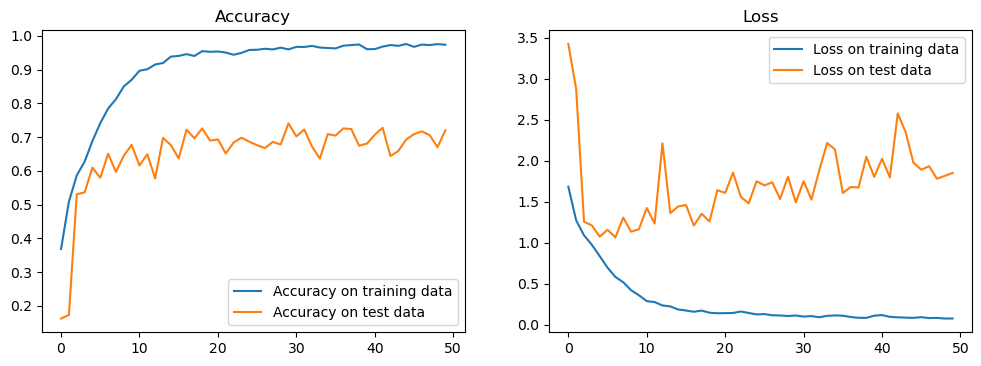

In [9]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

In [10]:
# use test images to predict
pred_lables = model.predict(test_images).argmax(axis=1)

Number of test data: 1600
Number of wrong predictions: 456


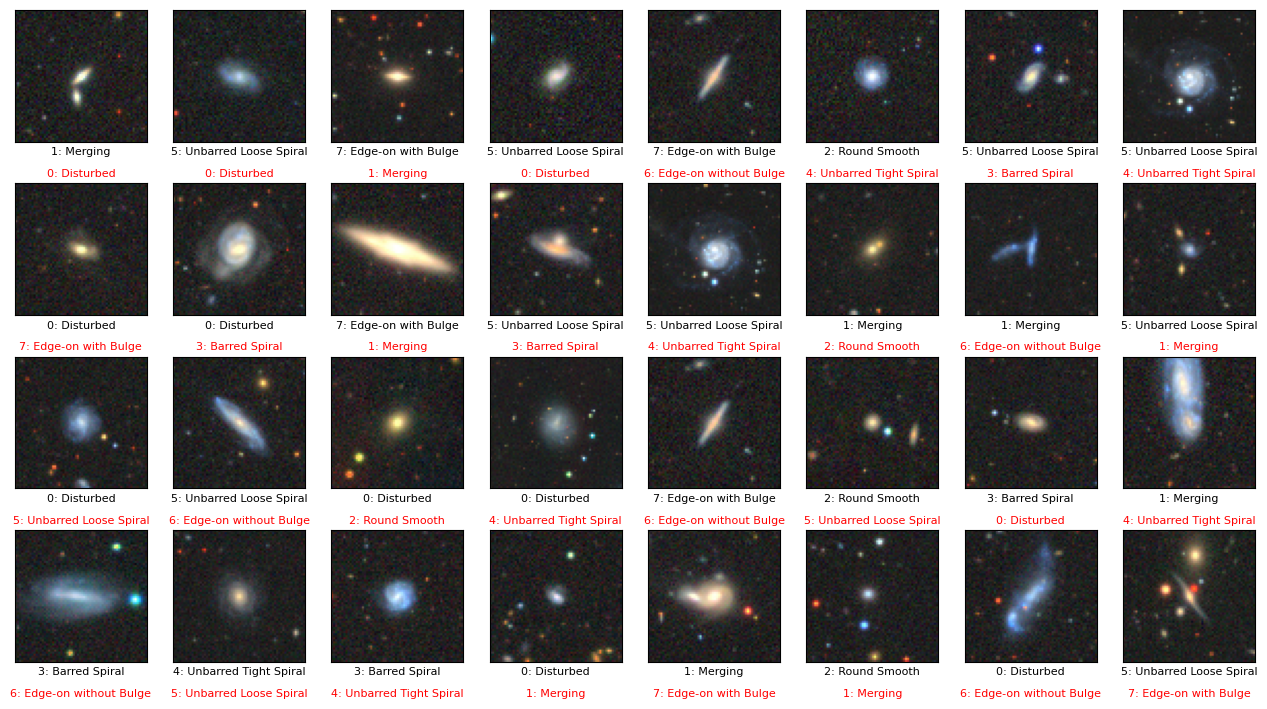

In [11]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 4. Exercises

* Classify a more complicated dataset, e.g., a randomly rotated galaxies as shown below. For the augmented dataset, compare the accuracy of a CNN and a fully connected DNN.  

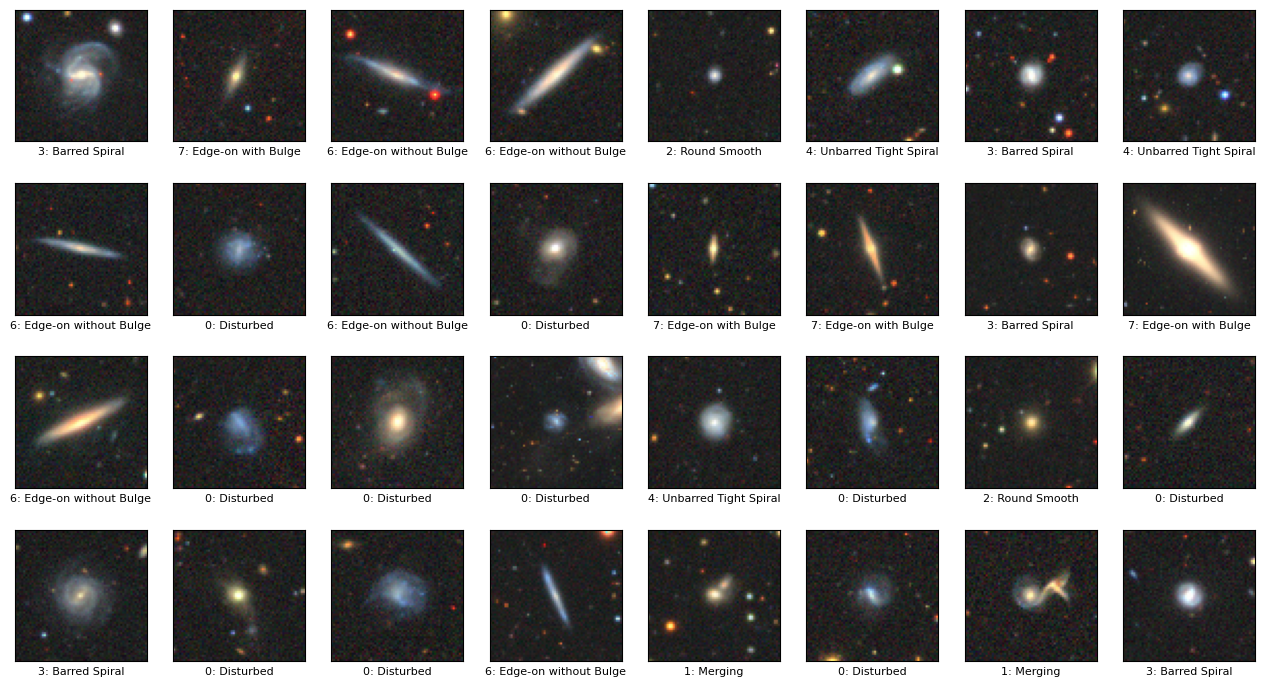

In [12]:
# rotate images randomly by k * 90 degrees
# train
train_images_rot = train_images.copy()
for i in np.arange(train_images.shape[0]):
    train_images_rot[i] = np.rot90(train_images[i], k=np.random.choice([0, 1, 2, 3]))
    
# test
test_images_rot = test_images.copy()
for i in np.arange(test_images.shape[0]):
    test_images_rot[i] = np.rot90(test_images[i], k=np.random.choice([0, 1, 2, 3]))
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images_rot[idata], label, nrows, ncols, iplot)
plt.show()